<a href="https://colab.research.google.com/github/maciejskorski/confidence_optimal_random_embed/blob/main/Best_DJL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confidence-Optimal Distributional Johnon-Lindenstrauss Transforms

This notebook implements the confidence-optimal random projections as discussed in https://www.researchgate.net/publication/348906028_Random_Projections_with_Best_Confidence.



In [12]:
m = 20
n = 10
eps = 0.01

from scipy.optimize import minimize
from scipy.stats import beta

def optimal_djl(m,n,eps):
  ''' best random embedding (confidence, construction params) '''
  a = n/2
  b = (m-n)/2
  z0 = a/(a+b)
  dist = beta(a,b) 
  fun = lambda z: -dist.cdf((1+eps)*z)+dist.cdf((1-eps)*z)
  betainc_jac = lambda z: dist.pdf(z)
  jac = lambda z: -(1+eps)*betainc_jac((1+eps)*z)+(1-eps)*betainc_jac((1-eps)*z)
  out = minimize(fun,x0=z0,jac=jac,method='Newton-CG')
  scale,delta = out.x,1+out.fun#/betainc(a,b,1)
  return scale,delta

import numpy as np
from scipy.optimize import bisect
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from matplotlib import pyplot as plt

def optimal_djl_dim(N,m,eps):
  ''' optimal dimension with many data points '''
  fun = lambda n: optimal_djl(m,n,eps)[1]-2/(N*(N-1))
  return bisect(fun,10,m-10)

optimal_djl(200,100,0.1)

(array([0.50501608]), 0.3148685077377392)

## Embeddings for multiple points 

Below we compare our and previous bounds on the minimal embedding dimension which guarantees the desired distortion (here $\epsilon=0.2$).

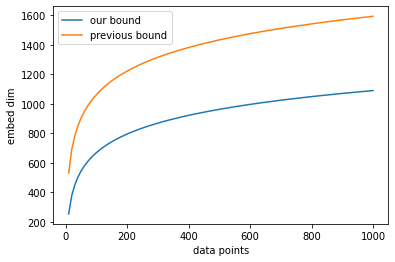

In [6]:
import numpy as np
from scipy.optimize import bisect
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from matplotlib import pyplot as plt

def optimal_djl_dim(N,m,eps):
  ''' optimal dimension with many data points '''
  fun = lambda n: optimal_djl(m,n,eps)[1]-2/(N*(N-1))
  return bisect(fun,10,m-10)

m = 1e5
eps = 0.2
sample = np.linspace(10,1000,100)
my_dim = [optimal_djl_dim(N,m,eps) for N in sample]
plt.plot(sample,my_dim,label='our bound')
their_dim = [johnson_lindenstrauss_min_dim(N,eps) for N in sample]
plt.plot(sample,their_dim,label='previous bound')
plt.legend()
plt.xlabel('# data points')
plt.ylabel('embed dim')
plt.show()

## Dependency on Feature Dimension

As opposed to prior works, our bound takes advantage of the data dimensionality.

In [4]:
import pandas as pd
df = pd.DataFrame([sample,my_dim,their_dim]).T
df.columns=['n. points','my_dim','their_dim']
df.to_csv('jl_dim.csv',index=False)

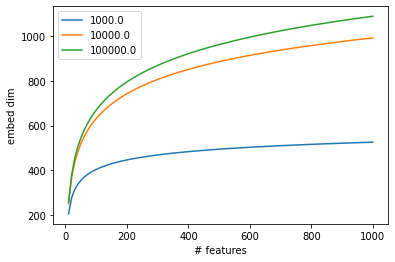

In [7]:
eps = 0.2
sample = np.linspace(10,1000,100)

my_dims = []

for m in [1e3,1e4,1e5]:
  my_dim = [optimal_djl_dim(N,m,eps) for N in sample] 
  my_dims.append(my_dim)
  plt.plot(sample,my_dim,label='%s'%m)
plt.legend()
plt.ylabel('embed dim')
plt.xlabel('# features')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(my_dims).T
df.columns = [1000,10000,100000]
df['sample'] = sample
df.to_csv('jl_feature_dim.csv',index=False)

## Approximate Formula

The sharp formula depends on a 1-D optimization problem. Below we test its closed-form approximation.



In [14]:
def approx_optimal_djl(m,n,eps):
  a = n/2
  b = (m-n)/2
  z0 = a/(a+b)
  dist = beta(a,b) 
  fun = lambda z: -dist.cdf((1+eps)*z)+dist.cdf((1-eps)*z)
  x = a/(a+b)
  scale,delta = x,1+fun(x)
  return scale,delta

def approx_optimal_djl_dim(N,m,eps):
  ''' approximated optimal dimension with many data points '''
  fun = lambda n: approx_optimal_djl(m,n,eps)[1]-2/(N*(N-1))
  return bisect(fun,10,m-10)

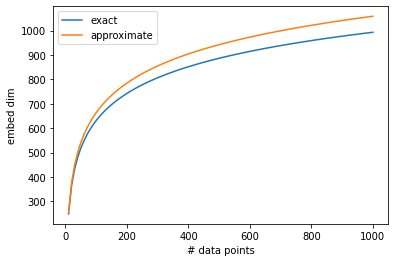

In [17]:
eps = 0.2
sample = np.linspace(10,1000,100)

m = 1e4
exact_dim = [optimal_djl_dim(N,m,eps) for N in sample] 
approx_dim = [approx_optimal_djl_dim(N,m,eps) for N in sample] 
plt.plot(sample,exact_dim,label='exact')
plt.plot(sample,approx_dim,label='approximate')
plt.ylabel('embed dim')
plt.xlabel('# data points')
plt.legend()
plt.show()

In [19]:
df = pd.DataFrame([sample,exact_dim,approx_dim]).T
df.columns = ['n. points','exact','approx']
df['sample'] = sample
df.to_csv('jl_approx_dim.csv',index=False)

## Sampling Unit Sphere

The important auxiliary result shows how to sample the unit sphere from Dirichlet Distribution. Below we visualize this technique.

In [ ]:
import numpy as np

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

from scipy import stats

def sample_dirichlet(size=1,dim=3):
  w = stats.dirichlet(0.5*np.ones(dim)).rvs(size=size)
  sign = np.random.choice([-1,1],size=(size,dim),p=[0.5,0.5])
  return sign*w**0.5

#sample_dirichlet(1).shape

xi, yi, zi = sample_dirichlet(3).T
xi, yi, zi = sample_spherical(3)

xi**2+yi**2+zi**2

array([1., 1., 1.])

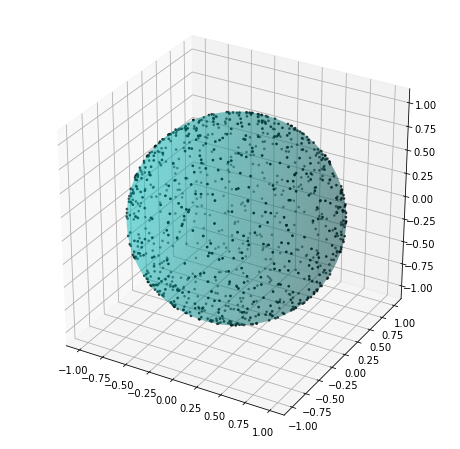

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy import stats

def sample_dirichlet(size=1,dim=3):
  w = stats.dirichlet(0.5*np.ones(dim)).rvs(size=size)
  sign = np.random.choice([-1,1],size=(size,dim),p=[0.5,0.5])
  return sign*w**0.5

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 120)
v = np.linspace(0, np.pi, 60)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha = 0.3, linewidth = 0)

xi, yi, zi = sample_dirichlet(1000).T
ax.scatter(xi, yi, zi,color="k",s=3)